# Densely Connected Convolutional Networks

## Introduction

If you like Neural Nets, you certainly have heard about VGGNet, Resnet, Inception Resnet, and others. These networks, each one in its time, reached state-of-the-art performance in some of the most famous challanges in Computer Vision. If we look at the short and successfull history of Deep Neural Networks, post the GPGPU and big data revolution, we notice that year by year, these models got more deeper and more powerful. As networks were getting more and more dense in the number of paramenters and layers, the problem of how to prevent the gradient from vanishing by the time it reaches the first layers of the network was something to worry about.

To address this issue, many network architectures emerged such as the Resnet and Highway networks. Besides some changes, all of them tried to solve this problem using one single approach - Create shortcut connections that bypasses a group of operations so that the gradient signal could be propagated without much loss from the end to the begining of the netowrk.

In this context, arouse the Densely Connected Convolutional Networks, DenseNets. 

I have been using this architecute for a while and I have experimented with both, image classification and densely prediction problems such as semantic segmentation. During this time, I developed a library to use DenseNets using Tensorflow with its Slim package. I really like this model and in this post, we are going to do an overview of this archtecture, compare it with other very popular ones, and show how one might use the Library for its own pleasure. 

## Archtecture

To understand DenseNets, we need to focus on two principal components of its archtecure. The Dense Block, and the Transition Layer. A DenseNet is basically a stack of dense blocks followed by transition layers. Each block consists of a series of units, each unit packs two convolution operations, each of which is preceeded by Batch Normalization and ReLU activations. In addition, each unit outputs only k feature vectors. This parameter k, also described as the growth rate, controls how much new information the layers allow to pass through.

On the other hand, transition layers are very simple components designed to perform downsampling of the features passing the network. Every transition layer consisits of a Batch Normalization layer, followed by a 1x1 convolution, followed by a 2x2 average pooling. 

The big difference however, from other regular CNNs, is that each unit within a dense block is connected to every other unit bofore it. In summary, within a given block, the nth unit, receices as input the feature-maps learned by the n-1th, n-2th all the way down to the 1st unit in the pipeline. As you might guess, it allows DenseNet models to carry very few parameters because there is a very high level of feature sharring amongst the units. We will talk more about number of parameters in a bit.

Different then the proposed ResNet archtecture, DenseNets propose feature reuse among units by concatenation. As a consequence of that archtecure choice, DenseNet models tend to be more compact (in the number of parameters) than ResNet models because every feature-map learned by any given DenseNet unit is reused by all of the following units within a block, avoinding the relearning of these same features. To get a better glance at it, let's have a look at the differences between a Resnet unit and a DenseNet unit. Both archtectures employ the so called bottleneck layer, where there is a 1x1 convolution designed to reduce the spatial dimentionallity, followed by a more wider convolution, in this case a 3x3 operation for feature learning. 

In its original form, the ResNet bottleneck layer consists of a 1x1 followed by a 3x3 followed by another 1x1 convolution, closing with an addition operation between the original input and the result of the non-linear transformations. This very elegant design gave the ResNet the ILSVRC 2015 classification task challenge chanpionship and since then, it inspired many others similar archtectures that improved upon it.

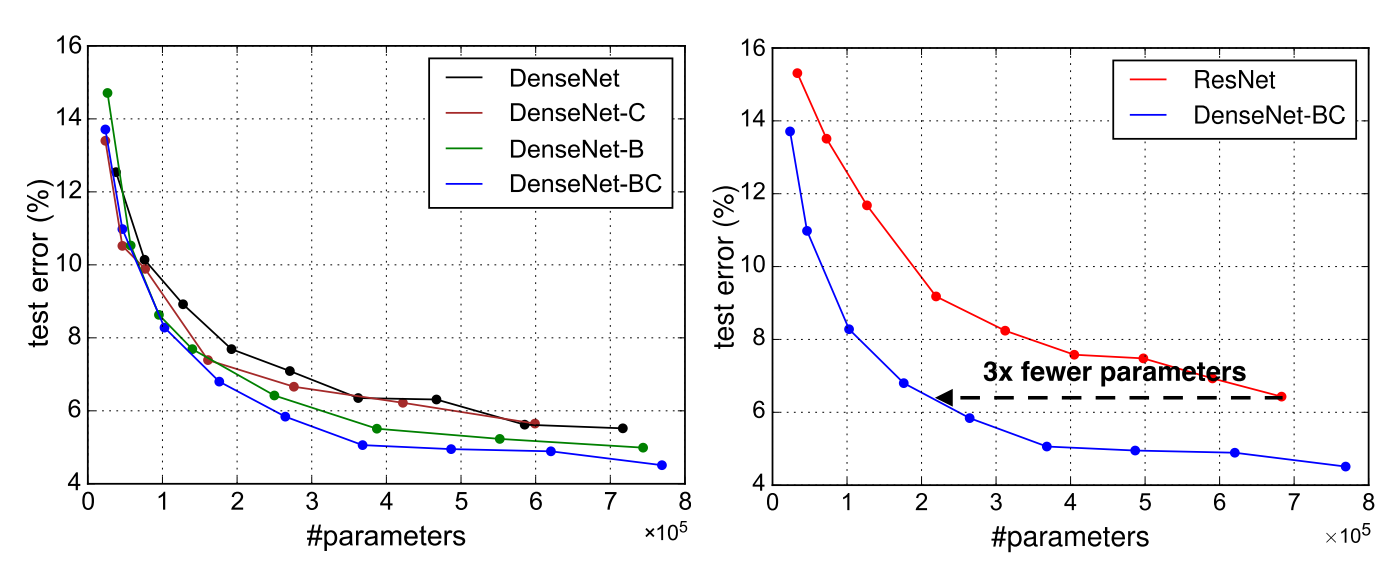

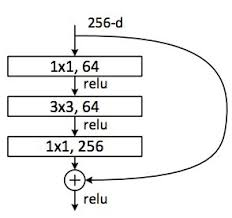

Similarly, DenseNets adds shortcut connections among all units within a block. The Densenet unit is not only simpler, (only 4 operations), but it also has the advantage of achieving very high level accuracy with a consideraded small growth rate factor. The main reason for that, is the fact that DenseNets minimize the learning of redundunt features in the various stages of the network because every block has direct access to the features already learned by the blocks before it. In fact, the authors argue that the maximization of feature reuse also makes the network easier to train. In addition, providing the feature maps learned by earlier layers increase the variation of the inputs that later layers receive, therefore improving parameter performance.

Because of that, in their paper, the authors showed that DenseNets were able to achieve smaller error rates using fewer parameters in various datasets like the SVHN, CIFAR10 and ImageNet when compared to the ResNet. 

In [1]:
import tensorflow as tf
slim = tf.contrib.slim
from densenet import densenet_121
from densenet_utils import densenet_arg_scope

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
inputs = tf.placeholder(tf.float32, shape=[None, 784])
inputs_ = tf.reshape(inputs, [-1, 28, 28, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [4]:
with slim.arg_scope(densenet_arg_scope()):
    with slim.arg_scope(densenet_arg_scope()):
        logits, end_points = densenet_121(inputs_, 10, output_stride=8, is_training=True)

In [5]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
merged_summary_op = tf.summary.merge_all()

In [7]:
saver = tf.train.Saver()

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          inputs: batch[0], y_: batch[1]})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={inputs: batch[0], y_: batch[1]})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      inputs: mnist.test.images, y_: mnist.test.labels}))

step 0, training accuracy 0.08
step 100, training accuracy 0.14
step 200, training accuracy 0.26
step 300, training accuracy 0.24
step 400, training accuracy 0.26
step 500, training accuracy 0.34
step 600, training accuracy 0.46
step 700, training accuracy 0.5
step 800, training accuracy 0.54
step 900, training accuracy 0.68
step 1000, training accuracy 0.7
step 1100, training accuracy 0.74
step 1200, training accuracy 0.72
step 1300, training accuracy 0.84
step 1400, training accuracy 0.88
step 1500, training accuracy 0.86
step 1600, training accuracy 0.92
step 1700, training accuracy 0.86
step 1800, training accuracy 0.88
step 1900, training accuracy 0.94
step 2000, training accuracy 0.88
step 2100, training accuracy 0.96
step 2200, training accuracy 0.86
step 2300, training accuracy 0.96
step 2400, training accuracy 0.98
step 2500, training accuracy 0.92
step 2600, training accuracy 0.98
step 2700, training accuracy 0.94
step 2800, training accuracy 0.96
step 2900, training accuracy